### Setup

In [1]:
# Import packages needed
import numpy as np
import pandas as pd
import pickle
import os
os.environ["H5PY_DEFAULT_READONLY"] = "1" # Surpress h5py deprecation warnings
import socket
from datetime import datetime
from seticore import viewer # If you don't have it, use pip install "git+https://github.com/MydonSolutions/seticore#egg=seticore&subdirectory=python"
import matplotlib.pyplot as plt
import setigen as stg
from astropy import units as u

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/nstiegle


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()
assert(hostname == 'cosmic-gpu-1')

### Code for looking at and dedrifting a single stamp

In [5]:
def investigate_stamp(stamp):
    snr_thresh = 8 # Threshold for SNR used when finding hits in seticore
    
    ### Look at the coherent first if this is coherent
    beam = stamp.stamp.signal.beam
    if beam >= 0:
        # Look at raw stamp
        print("Coherent Results:")
        try:
            stamp.show_best_beam(show_signal=True, title=f"Coherent Beam - " +
                                                         f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
                                                         f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
                                                         f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")
        except IndexError:
            beam = 0
            stamp.show_beam(beam, show_signal=True, title=f"Coherent Beam - " + 
                                                          f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
                                                          f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
                                                          f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")

    # Look at dedrifted stamp
    powers = stamp.beamform_power(beam)
    frame = stg.Frame.from_data(stamp.stamp.foff * u.MHz, stamp.stamp.tsamp * u.s, stamp.stamp.fch1 * u.MHz, True, powers)
    dedrifted = stg.dedrift(frame, stamp.stamp.signal.driftRate)
    fig = plt.figure(figsize=(15, 1.5))
    stg.plot(dedrifted)
    plt.title(f"Dedrifted Coherent Beam - " + 
              f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
              f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
              f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")
    plt.show()

    # Look at integrating columns of dedrifted stamp
    integrated = stg.integrate(dedrifted, mode='sum')
    fig = plt.figure(figsize=(15, 1.5))
    plt.xlabel("Frequency Bins (px)")
    plt.ylabel("Integrated Intensity After Dedrifting")
    plt.title(f"Dedrifted and Integrated Coherent Beam - " + 
              f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
              f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
              f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")
    plt.plot(integrated)

    ## Look at how SNR was calculated for this hit
    # Compute Statistics
    median = np.percentile(integrated, 50)
    top_5 = np.percentile(integrated, 95)
    bottom_5 = np.percentile(integrated, 5)
    center_data = integrated[(integrated < top_5) * (integrated > bottom_5)]
    std_dev = center_data.std()
    print("Local SNR of this stamp calculated using seticore method:", (max(integrated) - median) / std_dev)
    
    # Show snr histogram
    fig = plt.figure(figsize=(15, 1.5))
    plt.hist(integrated, bins=100)
    plt.axvline(top_5, dashes=[1, 1, 1, 1], color='red', label="Top 5%")
    plt.axvline(bottom_5, dashes=[1, 1, 1, 1], color='red', label="Botom 5%")
    plt.axvline(median, color='orange', label='median')
    plt.axvline(median + std_dev, color='yellow', dashes=[1, 1, 1, 1], label='+1std')
    plt.axvline(median - std_dev, color='yellow', dashes=[1, 1, 1, 1], label='-1std')
    plt.axvline(median + snr_thresh * std_dev, color='grey', dashes=[1, 1, 1, 1], label=f'+{snr_thresh}std')
    plt.axvline(max(integrated), color='purple', label='signal')
    plt.legend(loc='upper left')
    plt.title(f"Histogram of Dedrifted and Integrated Coherent Beam - " + 
            f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
            f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
            f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")    
    plt.xlabel("Integrated Column Intensity After Dedrifting")
    plt.ylabel("Count")
    plt.show()

    # Look at power over frequency but in snr unis
    fig = plt.figure(figsize=(15, 1.5))
    plt.plot((integrated - median) / std_dev)
    plt.axhline(snr_thresh, dashes=[1, 1, 1, 1], color='red', label=f"SNR = {snr_thresh}")
    plt.axhline(0, dashes=[1, 1, 1, 1], color='green', label="Calculated Noise Floor")
    plt.axhline(1, dashes=[1, 1, 1, 1], color='grey', label="+1std")
    plt.axhline(-1, dashes=[1, 1, 1, 1], color='grey', label="-1std")
    plt.ylabel("Standard Deviations above Noise Floor")
    plt.xlabel("Frequency Bin (px)")
    plt.legend()
    plt.title(f"Noise Calculation of Hit from Histogram Coherent Beam - " + 
            f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
            f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
            f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")
    plt.show()

    ## Look at how the signal changes with drift rate
    # Get snr of hit detected
    def give_snr_of_max(integrated):
        median = np.percentile(integrated, 50)
        top_5 = np.percentile(integrated, 95)
        bottom_5 = np.percentile(integrated, 5)
        center_data = integrated[(integrated < top_5) * (integrated > bottom_5)]
        std_dev = center_data.std()
        return (max(integrated) - median) / std_dev
    
    # Try stamp with variety of drift rates
    maxes = []
    medians = []
    snr_of_maxes = []
    drift_rates_to_try = np.arange(-50, 50, .125)
    for i, dr in enumerate(drift_rates_to_try):
        test_dedrifted = stg.dedrift(frame, dr)
        test_integrated = stg.integrate(test_dedrifted, mode='sum')
        peak = max(test_integrated)
        maxes.append(peak)
        median = np.median(test_integrated)
        medians.append(median)
        snr_of_max = give_snr_of_max(test_integrated)
        snr_of_maxes.append(snr_of_max)

    # Plot stamp with variety of drift rates
    plt.plot(drift_rates_to_try, snr_of_maxes)
    plt.scatter(stamp.stamp.signal.driftRate, give_snr_of_max(integrated), marker='o', color='red', label="Actual Drift Rate", zorder=100)
    plt.title(f"How Coherent Beam Hit Changes with Searched Drift Rate- " + 
              f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
              f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
              f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")
    plt.xlabel("Drift Rate Dedrifted (Hz/s)")
    plt.ylabel("SNR of Max Intensity")
    plt.legend()
    plt.show()

    # Look at what went into that plot
    plt.plot(drift_rates_to_try, maxes, label='Max')
    plt.plot(drift_rates_to_try, medians, label="Median")
    plt.title(f"How Coherent Beam Hit Changes with Searched Drift Rate- " + 
              f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
              f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
              f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")
    plt.xlabel("Drift Rate Dedrifted (Hz/s)")
    plt.ylabel("Intensity in Single Bin\nafter Dedrifting and Integrating")
    plt.legend(loc='lower center')
    plt.show()

    ### Look at incoherent beam
    # Look at same with incoherent
    incoherent = np.square(stamp.real_array()).sum(axis=(2, 3, 4))
    incoherent_frame = stg.Frame.from_data(stamp.stamp.foff * u.MHz, stamp.stamp.tsamp * u.s, stamp.stamp.fch1 * u.MHz, True, incoherent)
    incoherent_dedrifted = stg.dedrift(incoherent_frame, stamp.stamp.signal.driftRate)
    incoherent_integrated = stg.integrate(incoherent_dedrifted, mode='sum')
    fig = plt.figure(figsize=(15, 1.5))
    plt.plot(incoherent_integrated)
    plt.xlabel("Frequency Bins (px)")
    plt.ylabel("Integrated Intensity After Dedrifting")
    plt.title(f"Dedrifted and Integrated Incoherent Beam - " + 
              f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
              f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
              f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")
    plt.show()

### Look at result of dedrifting stamps

#### -49Hz/s signal from first stamp file 

Coherent Results:
best beam is 0
original power: 6.064391e+11
original SNR: 8.271747589111328
recalculated power: 6.078966e+11
local SNR: 7.224965785931368


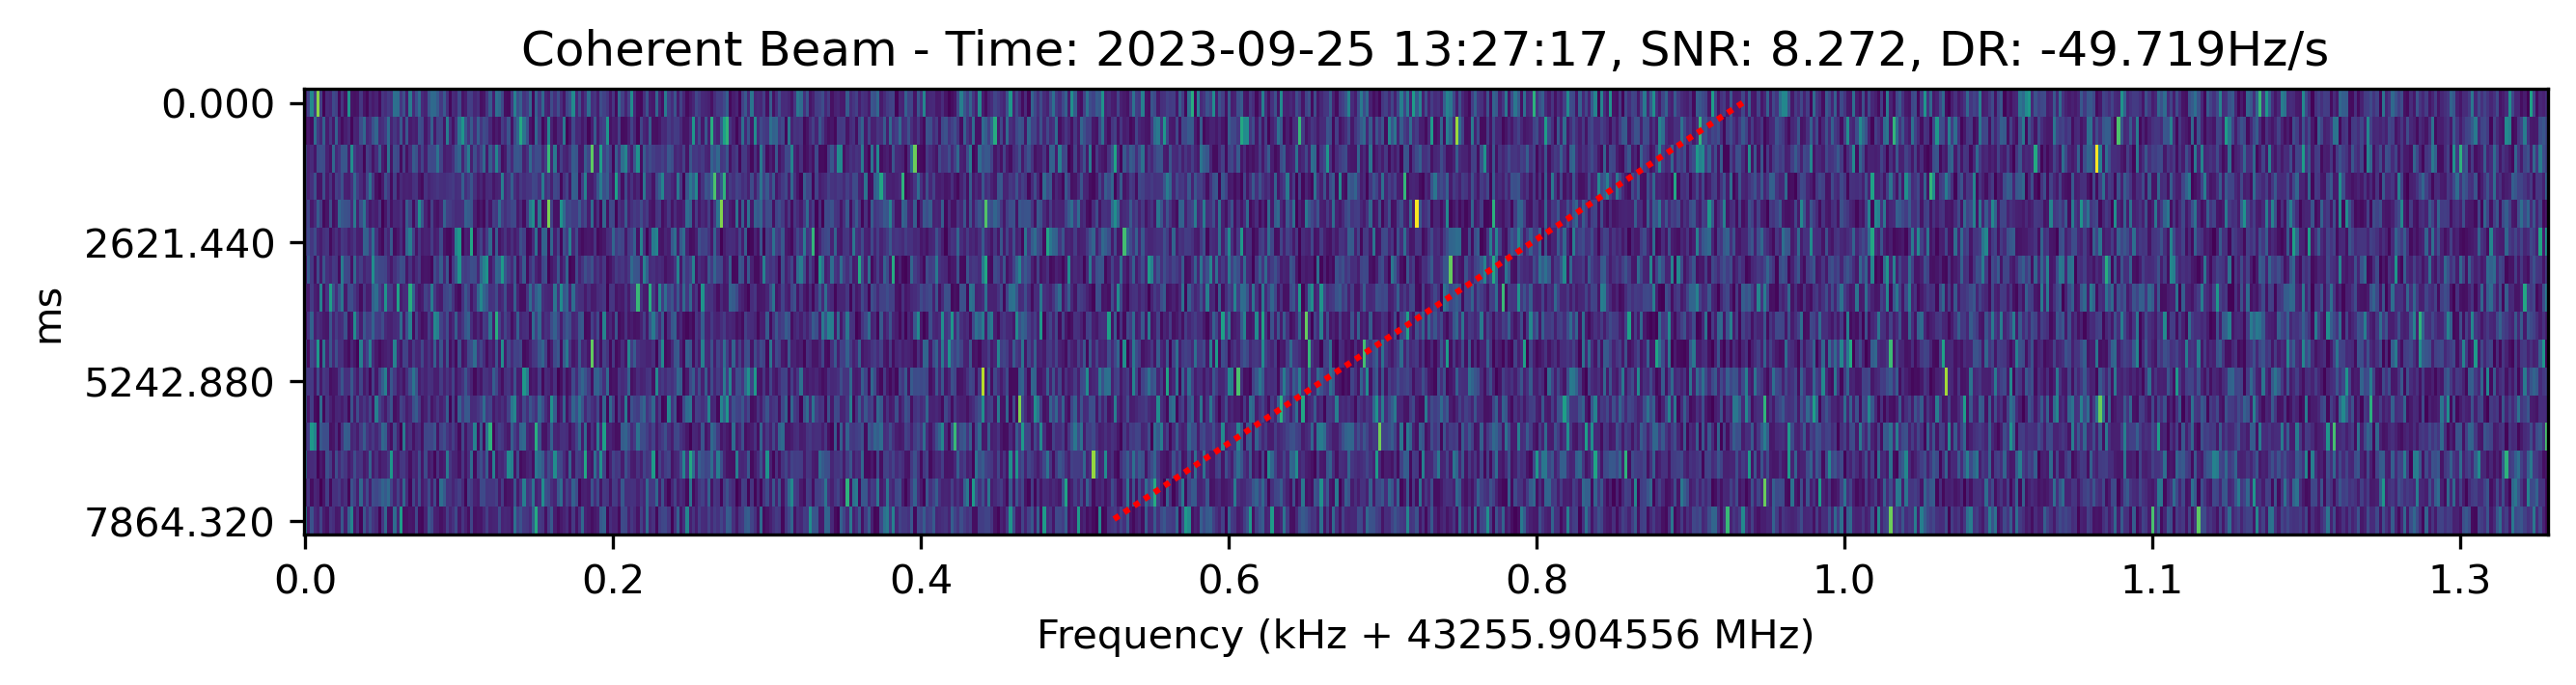

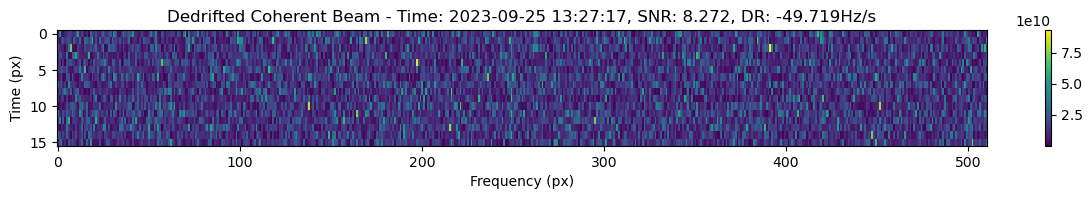

Local SNR of this stamp calculated using seticore method: 7.934928597208404


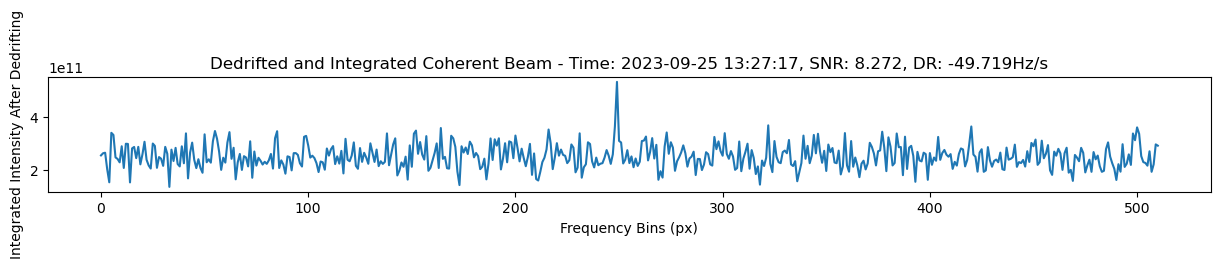

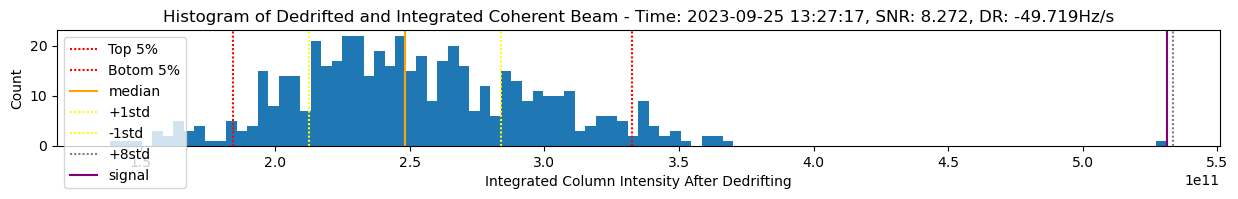

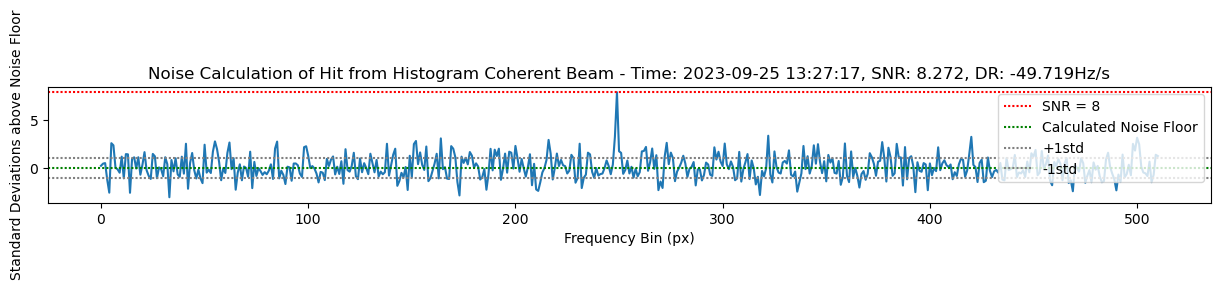

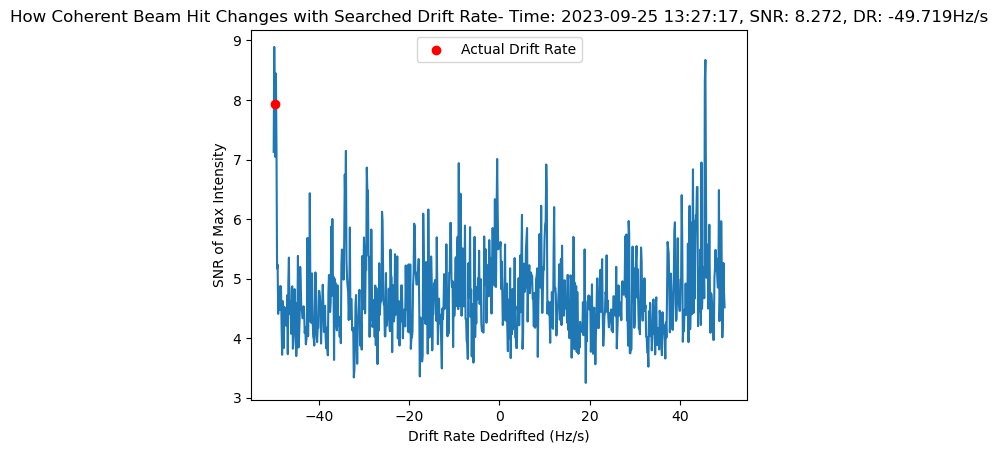

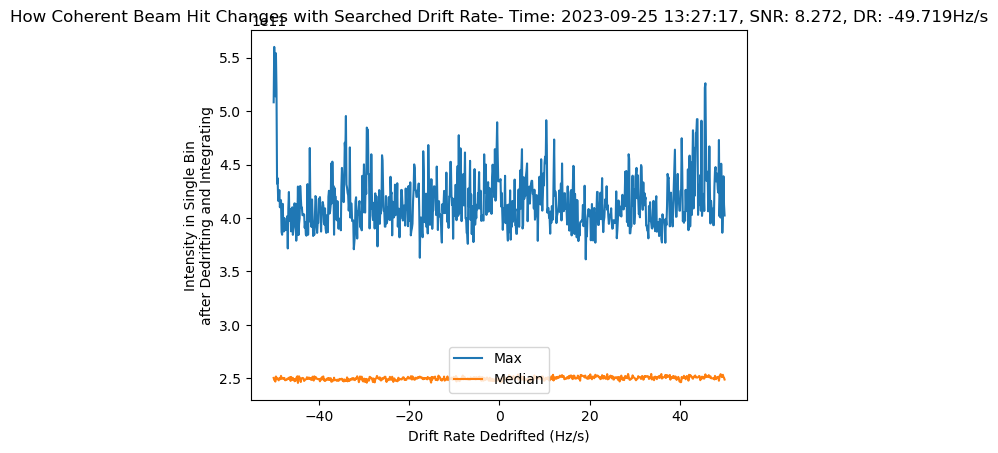

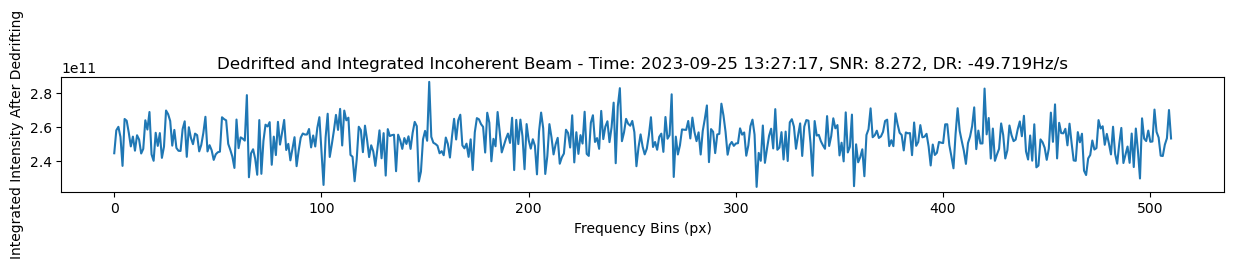

In [15]:
# Define where the data is
first_stamp_file = "/mnt/cosmic-storage-2/data1/vla_target/23A-362.sb43789194.eb44583327.60212.544836180554/23A-362.sb43789194.eb44583327.60212.544836180554.9.1/" + "23A-362.sb43789194.eb44583327.60212.544836180554.9.1.AC.C704.0000.raw.seticore.0000.stamps"
stamps = [stamp for stamp in viewer.read_stamps(first_stamp_file, find_recipe=True)]
stamp = stamps[28]
investigate_stamp(stamp)

#### Single Bright Pixel

Coherent Results:
best beam is 0
original power: 7.383181e+11
original SNR: 10.103474617004395
recalculated power: 7.372516e+11
local SNR: 3.9551799861154278


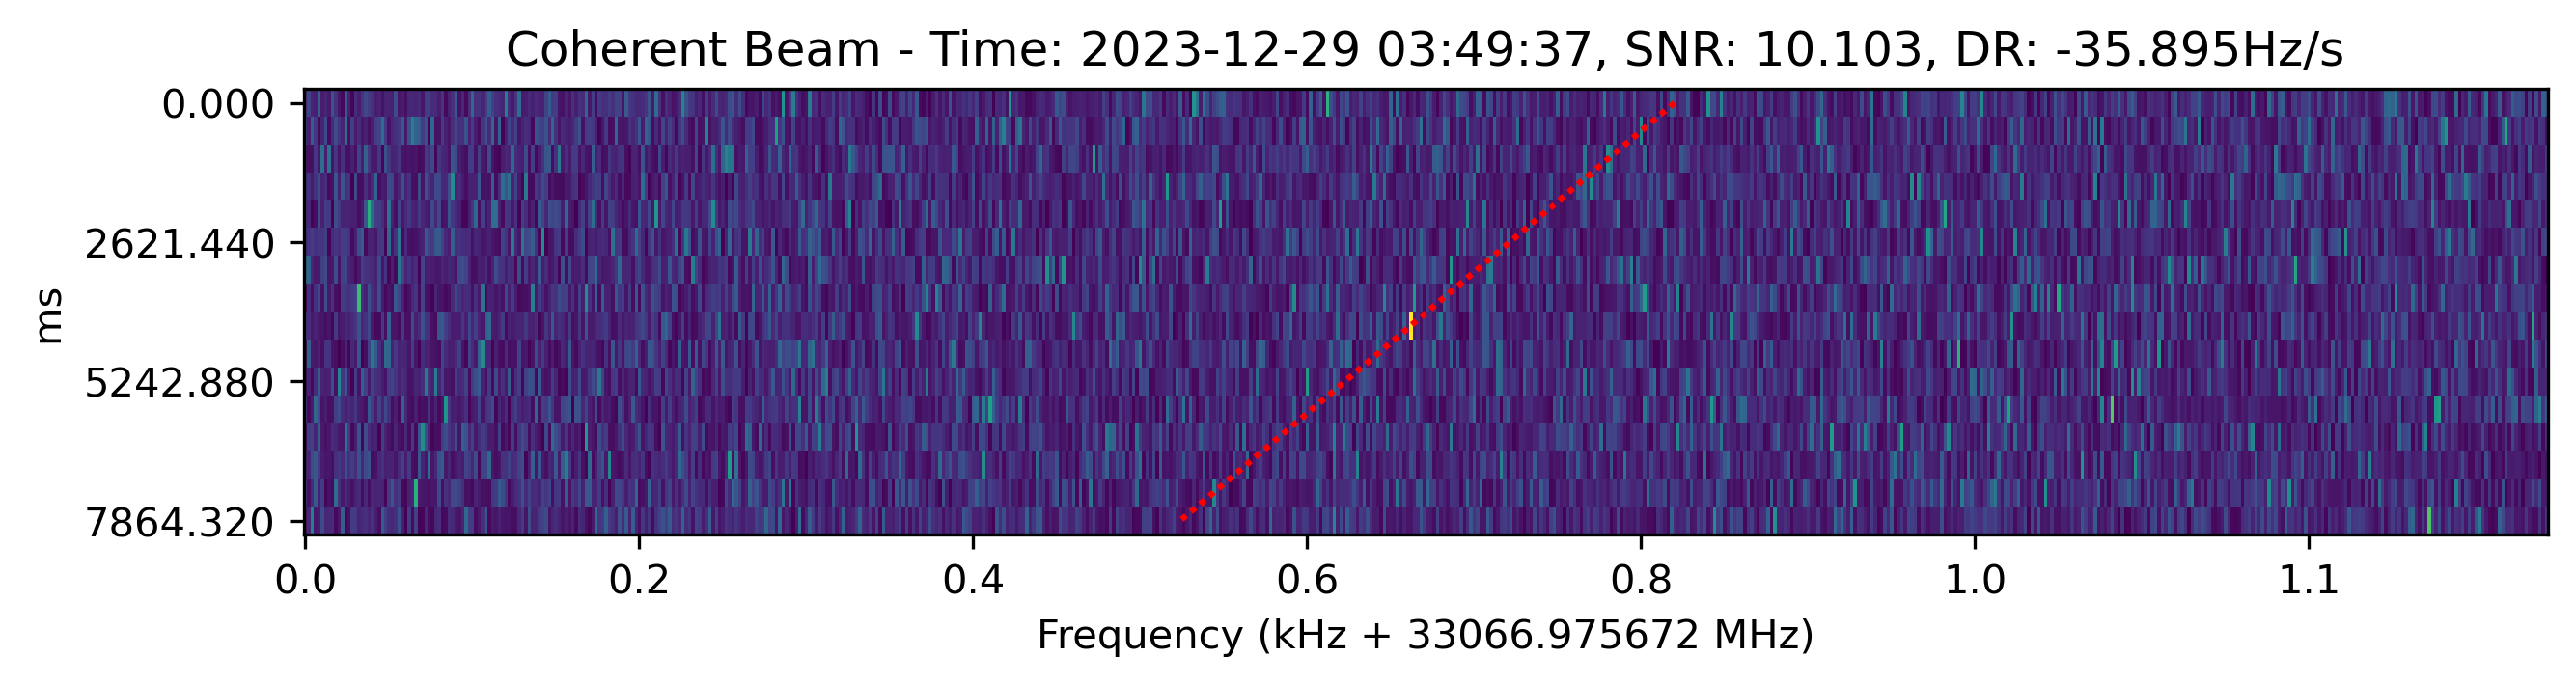

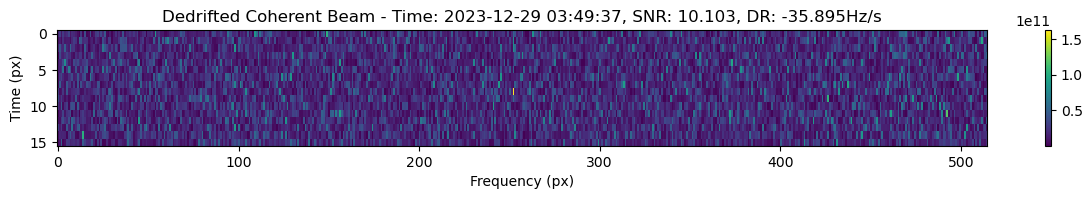

Local SNR of this stamp calculated using seticore method: 6.069600247030255


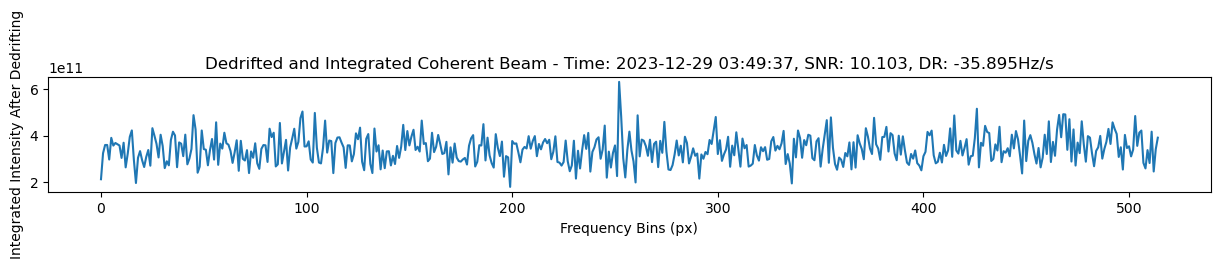

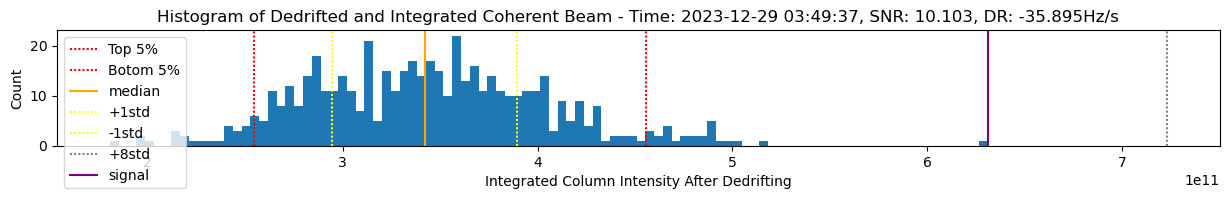

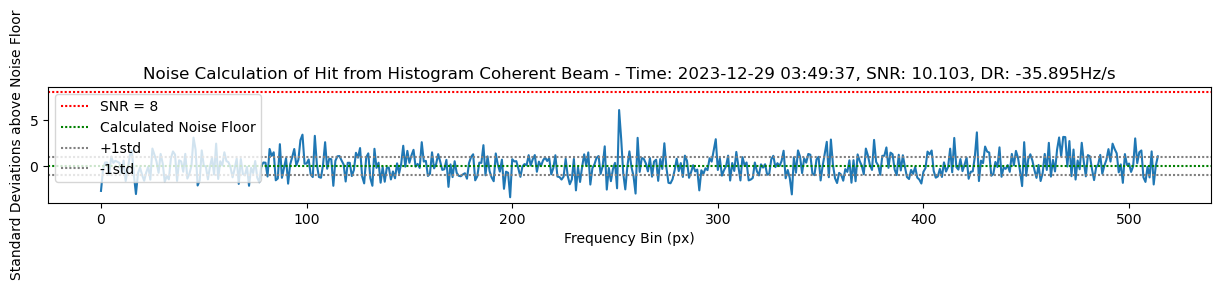

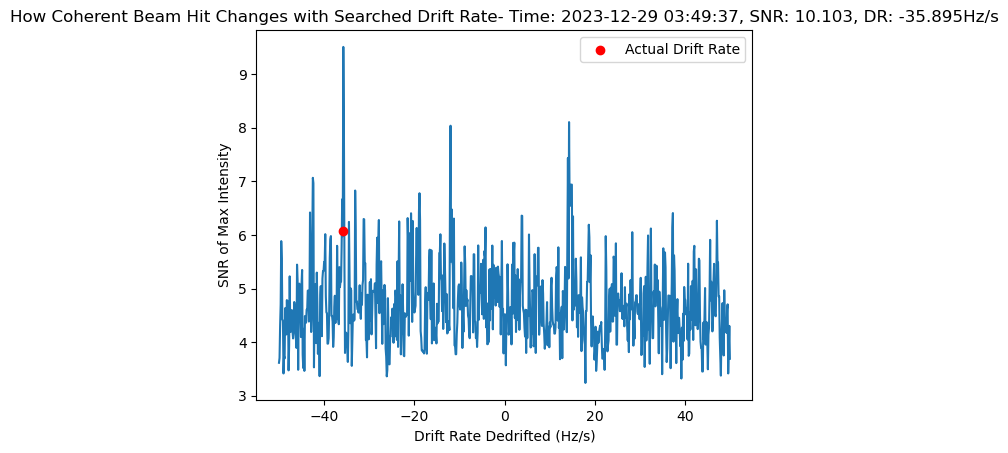

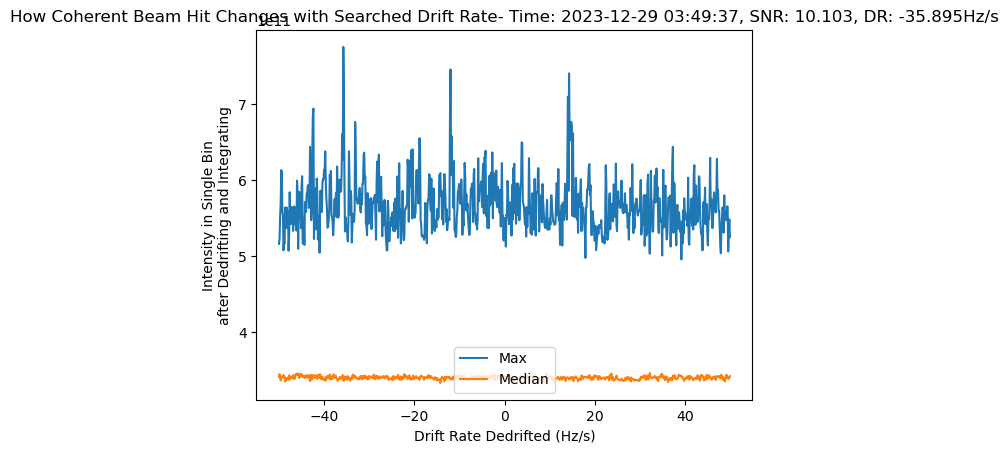

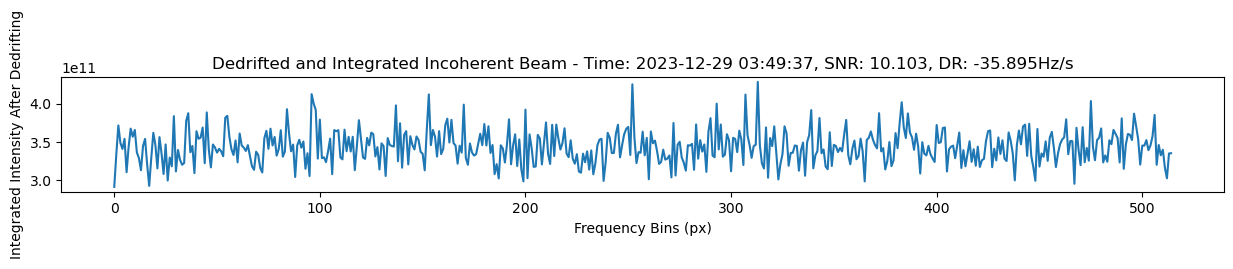

In [6]:
# Define where the data is
stamp_uri = "/mnt/cosmic-storage-1/data2/vla_target/23B-169.sb44930600.eb44962607.60307.145388159726/23B-169.sb44930600.eb44962607.60307.145388159726.9.1/23B-169.sb44930600.eb44962607.60307.145388159726.9.1.AC.C512.0000.raw.seticore.0000.stamps"
stamp_index = 98
stamps = [stamp for stamp in viewer.read_stamps(stamp_uri, find_recipe=True)]
stamp = stamps[stamp_index]
investigate_stamp(stamp)

#### Wide-band RFI

Coherent Results:
best beam is 1
original power: 9.584060e+09
original SNR: 23.394224166870117
recalculated power: 1.013614e+10
local SNR: 24.96350932558595


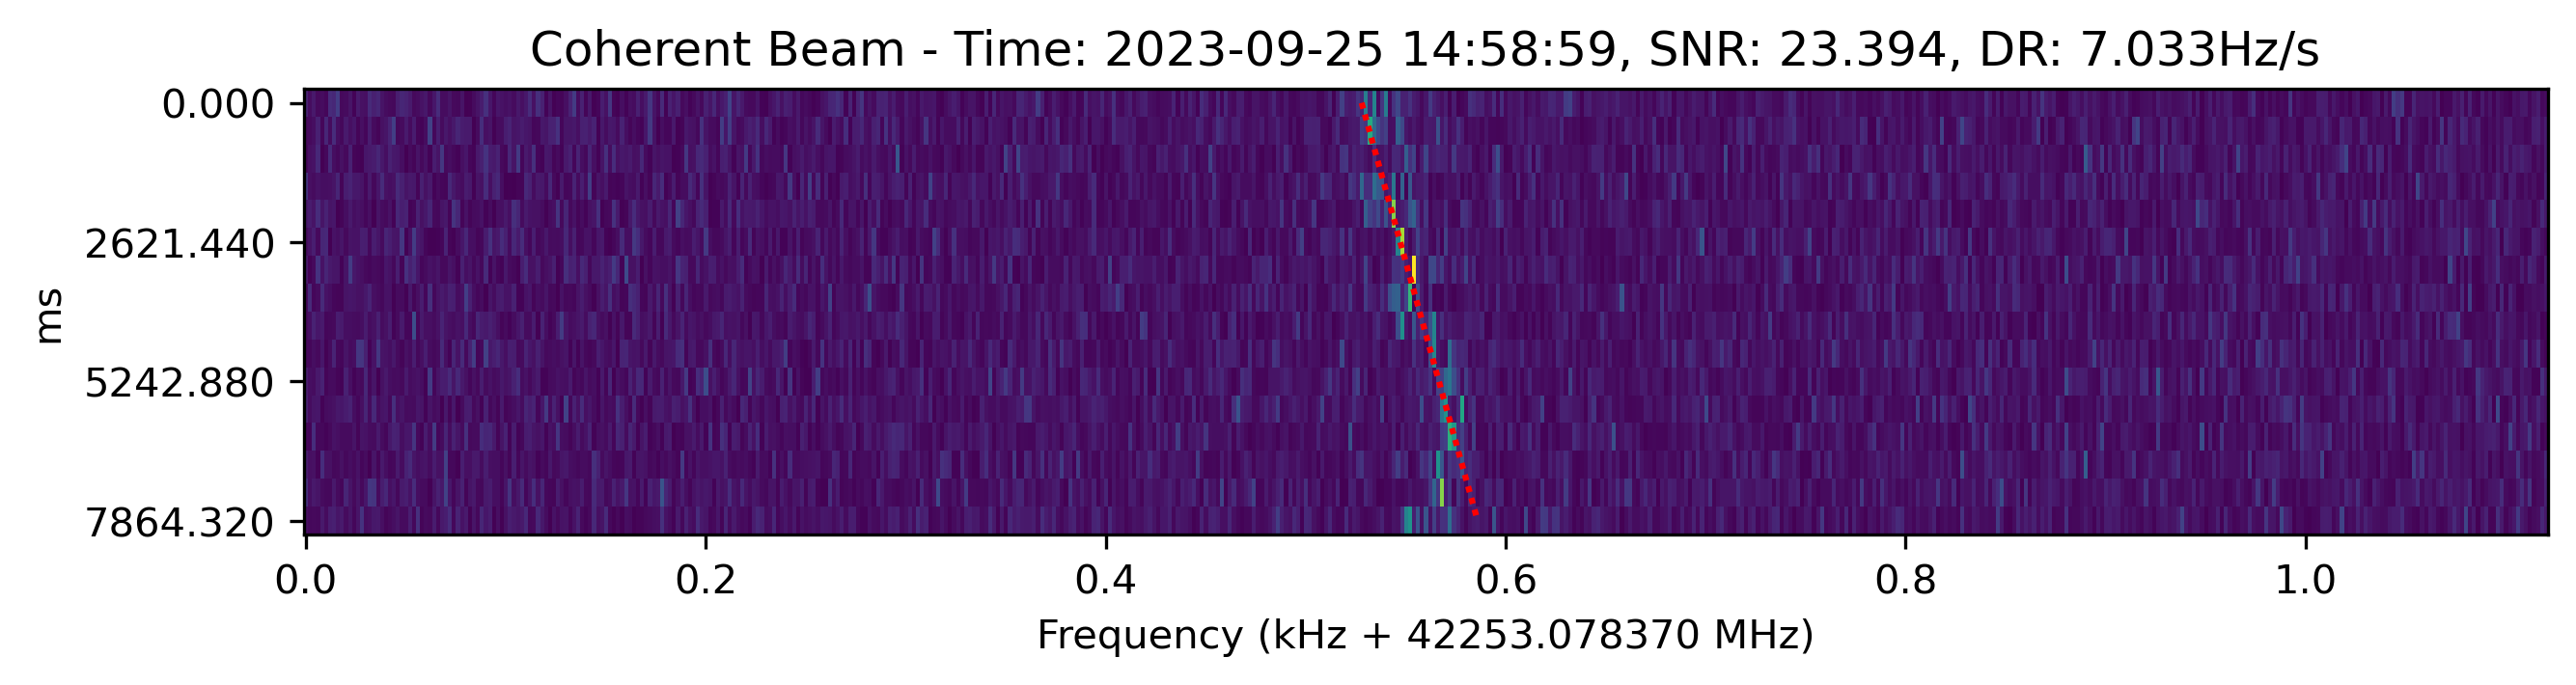

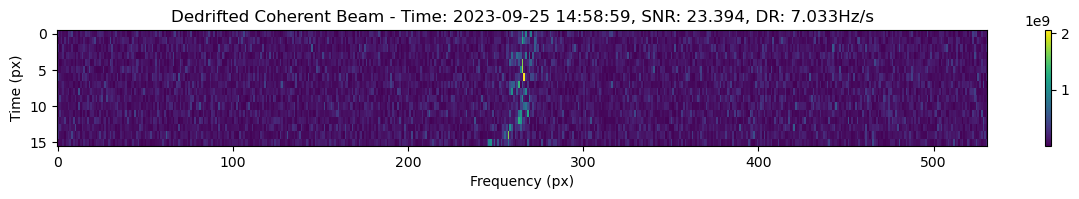

Local SNR of this stamp calculated using seticore method: 25.296318895283985


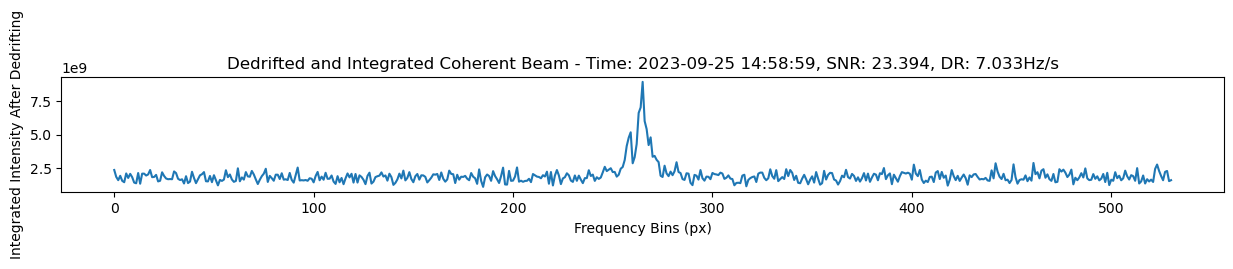

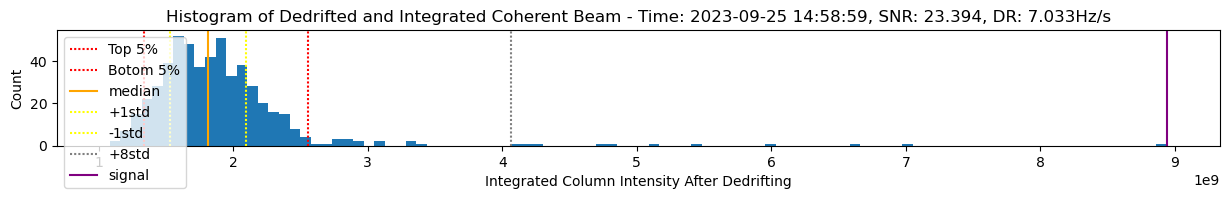

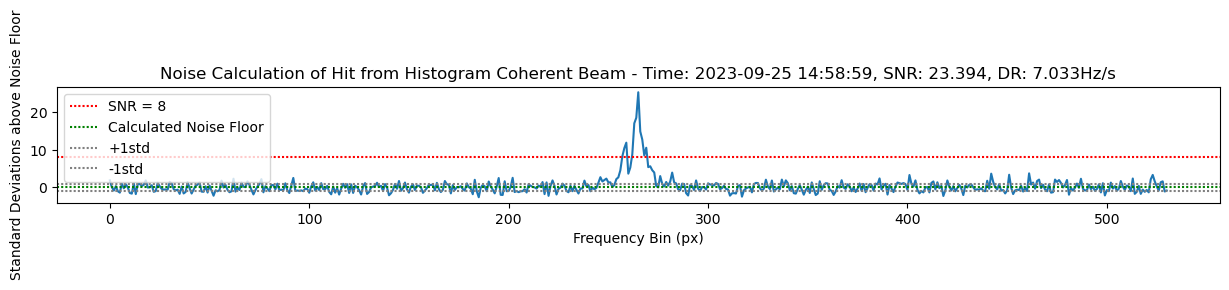

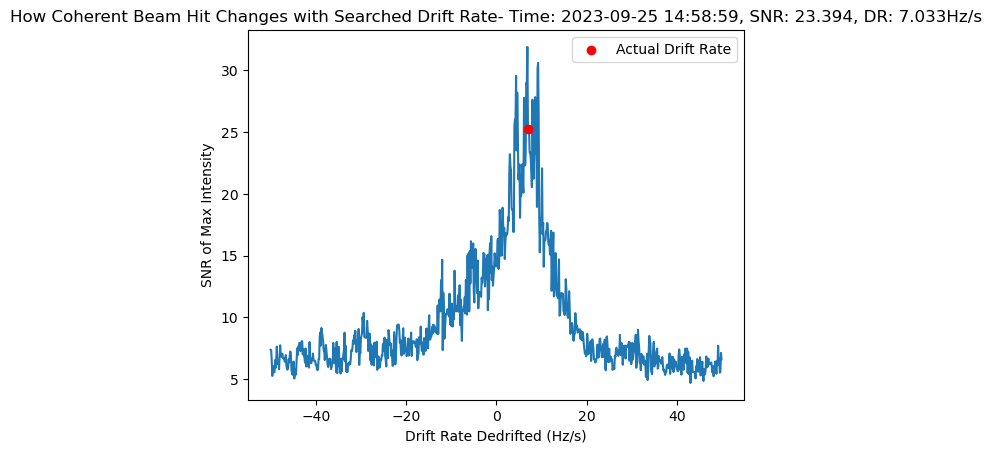

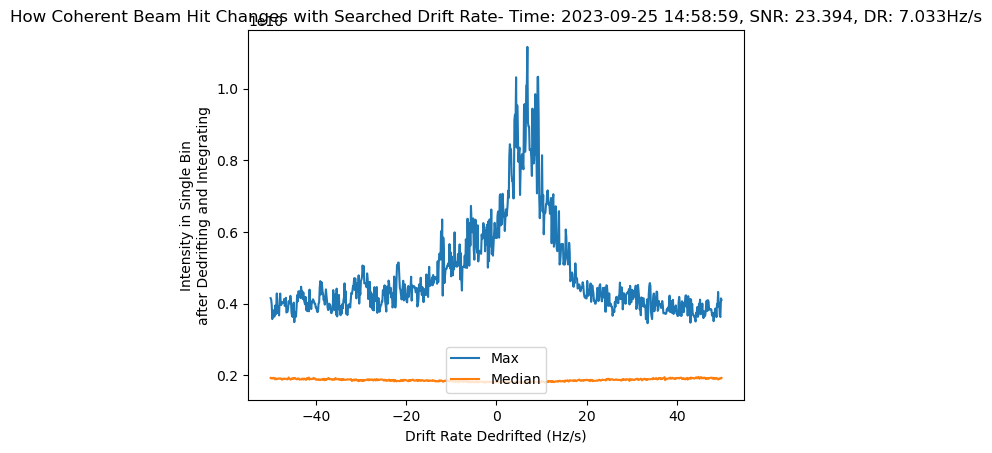

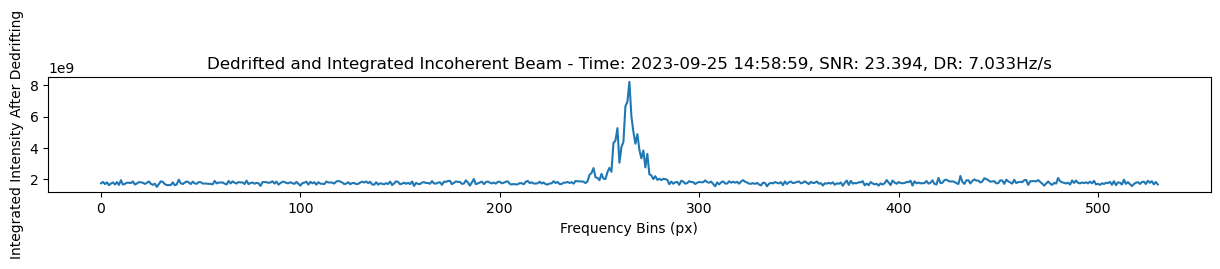

In [110]:
stamp_uri = "/mnt/cosmic-storage-2/data1/vla_target/23A-362.sb43789194.eb44583327.60212.544836180554/23A-362.sb43789194.eb44583327.60212.544836180554.101.1/23A-362.sb43789194.eb44583327.60212.544836180554.101.1.BD.C0.0000.raw.seticore.0000.stamps"
idx = 302
stamps = [stamp for stamp in viewer.read_stamps(stamp_uri, find_recipe=True)]
stamp = stamps[idx]
investigate_stamp(stamp)

### Plots with Fake Data for Presenation

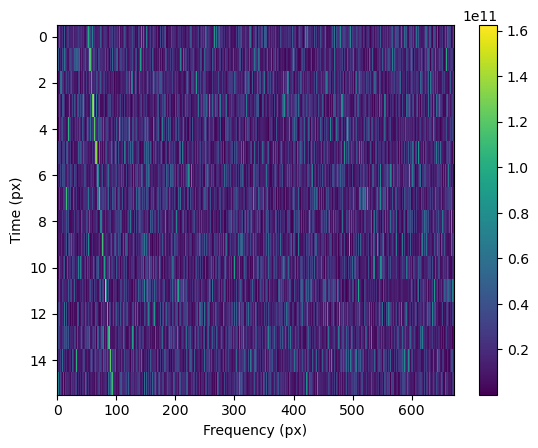

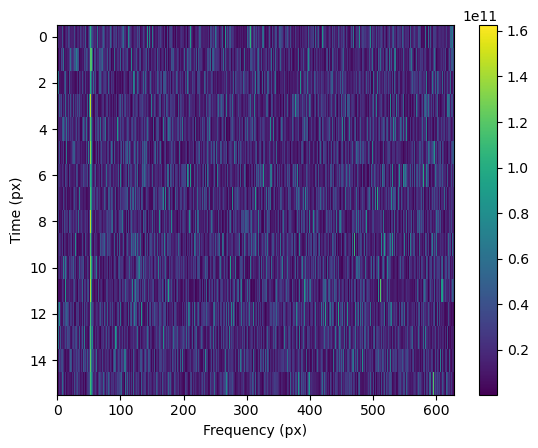

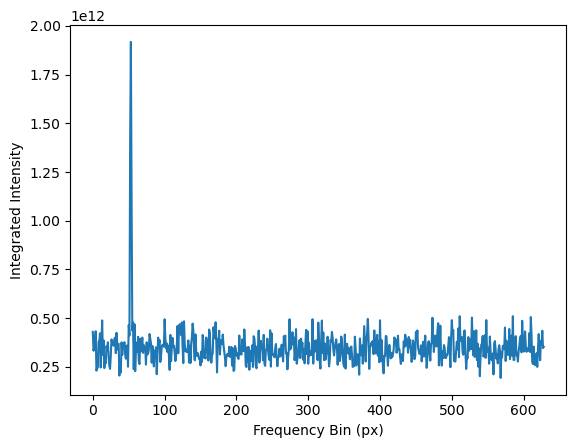

In [34]:
# Generate example data for presentation

# Define where the data is
stamp_uri = "/mnt/cosmic-storage-1/data2/vla_target/23B-169.sb44930600.eb44962607.60307.145388159726/23B-169.sb44930600.eb44962607.60307.145388159726.9.1/23B-169.sb44930600.eb44962607.60307.145388159726.9.1.AC.C512.0000.raw.seticore.0000.stamps"
stamp_index = 98
stamps = [stamp for stamp in viewer.read_stamps(stamp_uri, find_recipe=True)]
stamp = stamps[stamp_index]

# Load data
beam = 0
powers = stamp.beamform_power(beam)
frame = stg.Frame.from_data(stamp.stamp.foff * u.MHz, stamp.stamp.tsamp * u.s, stamp.stamp.fch1 * u.MHz, True, powers)

# Inject fake data
injected_data = frame.add_constant_signal(stamp.stamp.fch1 * u.MHz + 100 * u.Hz, 9.8 * u.Hz / u.s, 1e11, 4 * u.Hz)
frame = stg.Frame.from_data(stamp.stamp.foff * u.MHz, stamp.stamp.tsamp * u.s, stamp.stamp.fch1 * u.MHz, True, injected_data + powers)
frame.plot()
plt.show()

# Dedrift data
dedrifted = stg.dedrift(frame, 9.8)
dedrifted.plot()
plt.show()

# Integrate data
integrated = stg.integrate(dedrifted, mode='sum')
plt.plot(integrated)
plt.xlabel("Frequency Bin (px)")
plt.ylabel("Integrated Intensity")
plt.show()


In [87]:
def interpolate_drift(total_drift, timesteps):
    """Returns a list of drifts, one for each timestep, to get to a total of total_drift.
    Must start with 0 and end with total_drift.
    """
    def round_up_power_of_two(n):
        assert n >= 1
        answer = 1
        while answer < n:
            answer *= 2
        return answer
    
    rounded_up = round_up_power_of_two(timesteps)
    if rounded_up > timesteps:
        return interpolate_drift(total_drift, rounded_up)[:timesteps]
        
    assert("{0:b}".format(timesteps).count("1") == 1)
    if timesteps == 2:
        return [0, total_drift]
    assert timesteps > 2
    assert timesteps % 2 == 0

    if total_drift < 0:
        return [-x for x in interpolate_drift(-total_drift, timesteps)]
    
    shift = total_drift // (timesteps - 1)
    if shift > 0:
        post_shift_drift = total_drift % (timesteps - 1)
        post_shift_interpolate = interpolate_drift(post_shift_drift, timesteps)
        return [i * shift + x for (i, x) in enumerate(post_shift_interpolate)]
    
    parity = total_drift % 2
    half_drift = total_drift // 2
    assert half_drift * 2 + parity == total_drift
    half_interpolate = interpolate_drift(half_drift, timesteps // 2)
    second_half_start = half_interpolate[-1] + parity
    return half_interpolate + [x + second_half_start for x in half_interpolate]

In [109]:
# fig = plt.figure(figsize=(100, 40))
# data = injected_data + powers
# # data[:, :20] = data.max()
# # data[:, -20:] = data.max()
# mask = np.zeros(data.shape,
#                 dtype=bool)
# drifts = interpolate_drift(40, stamp.stamp.signal.numTimesteps)
# hit_offset = 53
# for timestep, drift in enumerate(drifts):
#     mask[timestep, hit_offset + drift] = True
# data[mask] = data.max() * 2
# plt.imshow(data, aspect="auto")
# plt.show()

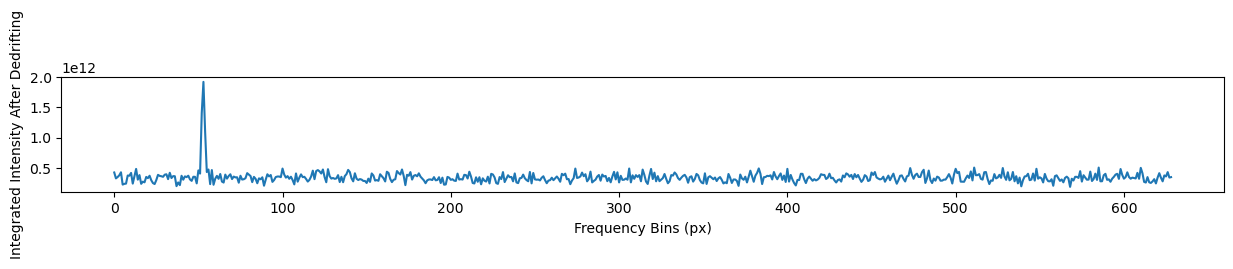

In [36]:
# Look at integrating columns of dedrifted stamp
fig = plt.figure(figsize=(15, 1.5))
plt.xlabel("Frequency Bins (px)")
plt.ylabel("Integrated Intensity After Dedrifting")
plt.plot(integrated)


In [37]:

## Look at how SNR was calculated for this hit
# Compute Statistics
median = np.percentile(integrated, 50)
top_5 = np.percentile(integrated, 95)
bottom_5 = np.percentile(integrated, 5)
center_data = integrated[(integrated < top_5) * (integrated > bottom_5)]
std_dev = center_data.std()
print("Local SNR of this stamp calculated using seticore method:", (max(integrated) - median) / std_dev)


Local SNR of this stamp calculated using seticore method: 32.42571893445482


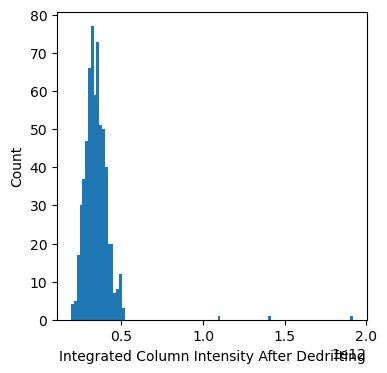

In [62]:
fig = plt.figure(figsize=(4, 4))
plt.hist(integrated, bins=100)
plt.xlabel("Integrated Column Intensity After Dedrifting")
plt.ylabel("Count")
plt.show()

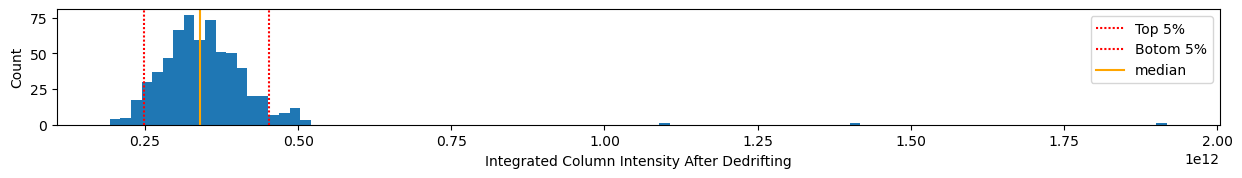

In [46]:

# Show snr histogram
fig = plt.figure(figsize=(15, 1.5))
plt.hist(integrated, bins=100)
plt.axvline(top_5, dashes=[1, 1, 1, 1], color='red', label="Top 5%")
plt.axvline(bottom_5, dashes=[1, 1, 1, 1], color='red', label="Botom 5%")
plt.axvline(median, color='orange', label='median')
# plt.axvline(median + snr_thresh * std_dev, color='grey', dashes=[1, 1, 1, 1], label=f'+{snr_thresh}std')
plt.legend(loc='upper right') 
plt.xlabel("Integrated Column Intensity After Dedrifting")
plt.ylabel("Count")
plt.show()


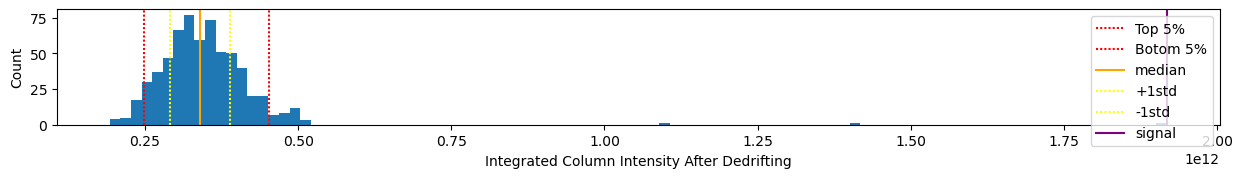

In [48]:

# Show snr histogram
fig = plt.figure(figsize=(15, 1.5))
plt.hist(integrated, bins=100)
plt.axvline(top_5, dashes=[1, 1, 1, 1], color='red', label="Top 5%")
plt.axvline(bottom_5, dashes=[1, 1, 1, 1], color='red', label="Botom 5%")
plt.axvline(median, color='orange', label='median')
plt.axvline(median + std_dev, color='yellow', dashes=[1, 1, 1, 1], label='+1std')
plt.axvline(median - std_dev, color='yellow', dashes=[1, 1, 1, 1], label='-1std')
# plt.axvline(median + snr_thresh * std_dev, color='grey', dashes=[1, 1, 1, 1], label=f'+{snr_thresh}std')
plt.axvline(max(integrated), color='purple', label='signal')
plt.legend(loc='upper right')
plt.xlabel("Integrated Column Intensity After Dedrifting")
plt.ylabel("Count")
plt.show()


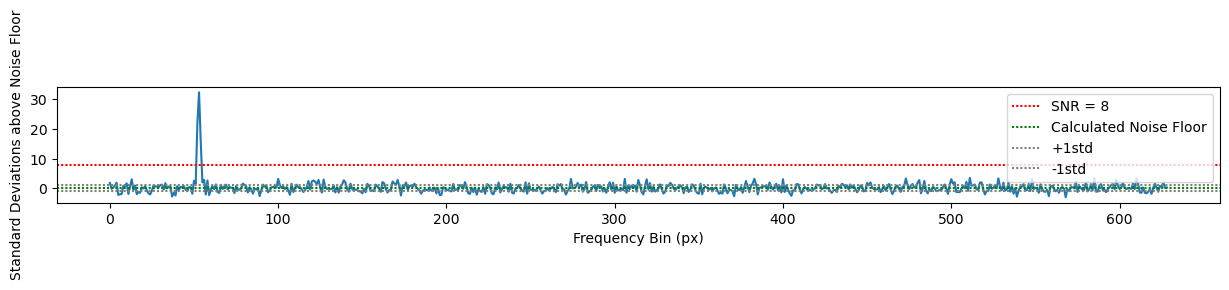

In [53]:

# Look at power over frequency but in snr unis
fig = plt.figure(figsize=(15, 1.5))
plt.plot((integrated - median) / std_dev)
plt.axhline(8, dashes=[1, 1, 1, 1], color='red', label=f"SNR = {8}")
plt.axhline(0, dashes=[1, 1, 1, 1], color='green', label="Calculated Noise Floor")
plt.axhline(1, dashes=[1, 1, 1, 1], color='grey', label="+1std")
plt.axhline(-1, dashes=[1, 1, 1, 1], color='grey', label="-1std")
plt.ylabel("Standard Deviations above Noise Floor")
plt.xlabel("Frequency Bin (px)")
plt.legend(loc='upper right')
plt.show()


In [54]:

## Look at how the signal changes with drift rate
# Get snr of hit detected
def give_snr_of_max(integrated):
    median = np.percentile(integrated, 50)
    top_5 = np.percentile(integrated, 95)
    bottom_5 = np.percentile(integrated, 5)
    center_data = integrated[(integrated < top_5) * (integrated > bottom_5)]
    std_dev = center_data.std()
    return (max(integrated) - median) / std_dev


In [55]:

# Try stamp with variety of drift rates
maxes = []
medians = []
snr_of_maxes = []
drift_rates_to_try = np.arange(-50, 50, .125)
for i, dr in enumerate(drift_rates_to_try):
    test_dedrifted = stg.dedrift(frame, dr)
    test_integrated = stg.integrate(test_dedrifted, mode='sum')
    peak = max(test_integrated)
    maxes.append(peak)
    median = np.median(test_integrated)
    medians.append(median)
    snr_of_max = give_snr_of_max(test_integrated)
    snr_of_maxes.append(snr_of_max)


matplotlib.legend WARNING  No handles with labels found to put in legend.


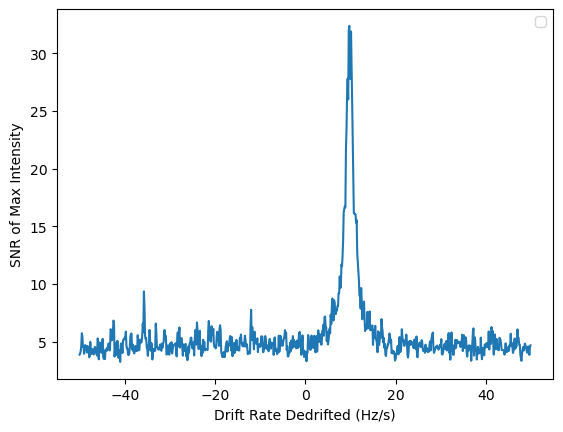

In [61]:

# Plot stamp with variety of drift rates
plt.plot(drift_rates_to_try, snr_of_maxes)
# plt.scatter(stamp.stamp.signal.driftRate, give_snr_of_max(integrated), marker='o', color='red', label="Actual Drift Rate", zorder=100)
plt.xlabel("Drift Rate Dedrifted (Hz/s)")
plt.ylabel("SNR of Max Intensity")
plt.legend()
plt.show()


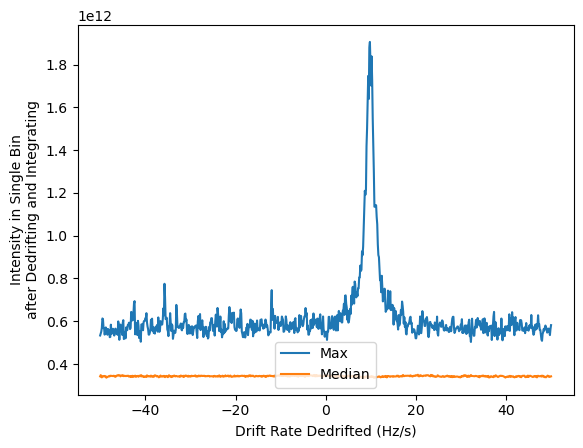

In [60]:

# Look at what went into that plot
plt.plot(drift_rates_to_try, maxes, label='Max')
plt.plot(drift_rates_to_try, medians, label="Median")
plt.xlabel("Drift Rate Dedrifted (Hz/s)")
plt.ylabel("Intensity in Single Bin\nafter Dedrifting and Integrating")
plt.legend(loc='lower center')
plt.show()